# About skills_detector.ipynb

This notebook detects skills in log files suchs as CVS.
This is a work in progress :)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages

## Let's detect use of different skills in 2 students
We are going to load the activity of 2 students: one who clearly uses a quantitative version of CVS in Beers sim and one who does not do CVS in Caps sim. We analyze their tables to detect use of CVS.
### First we load their log data

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


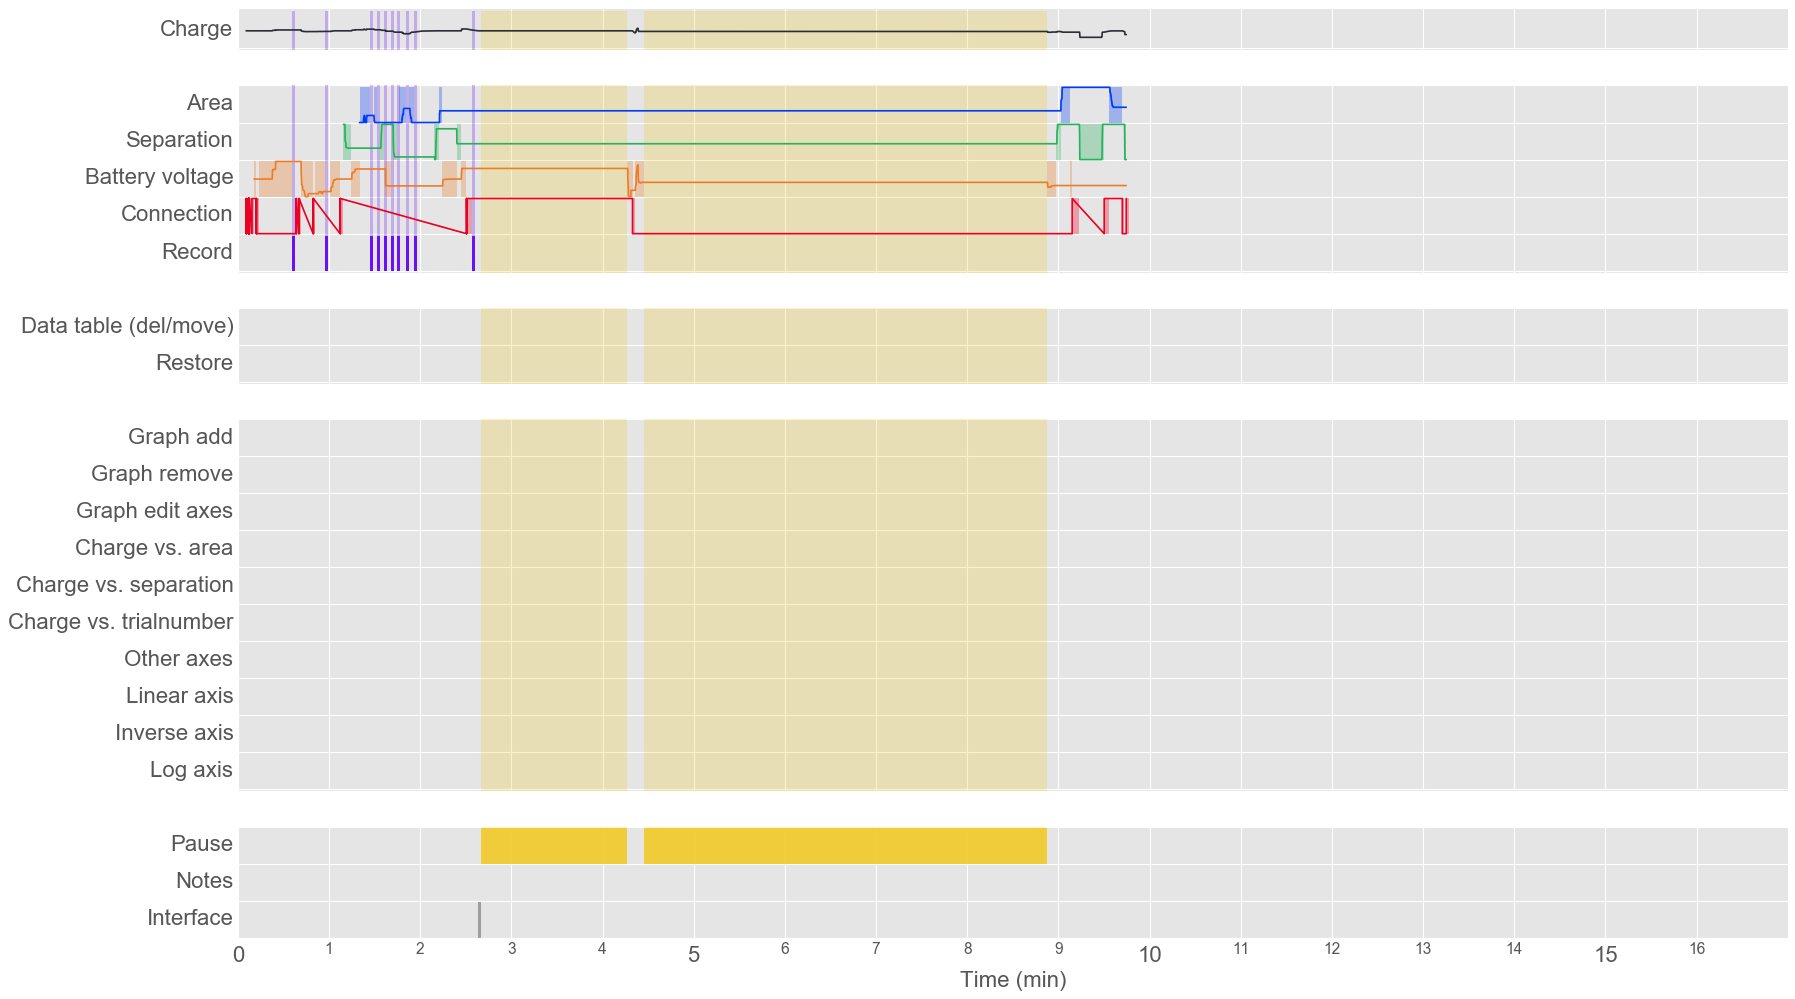

In [2]:
%aimport utils_timeline_viz
studentid = '17931169'
#main, cdw = 231
parsed_file = find_student_log_file("capacitor",studentid)#,date='2017-03-21_17.28.42')
df1 = prep_parsing_data(parsed_file)
plot(df1,to_plot_caps,family_name_to_code,function_to_use,colors)

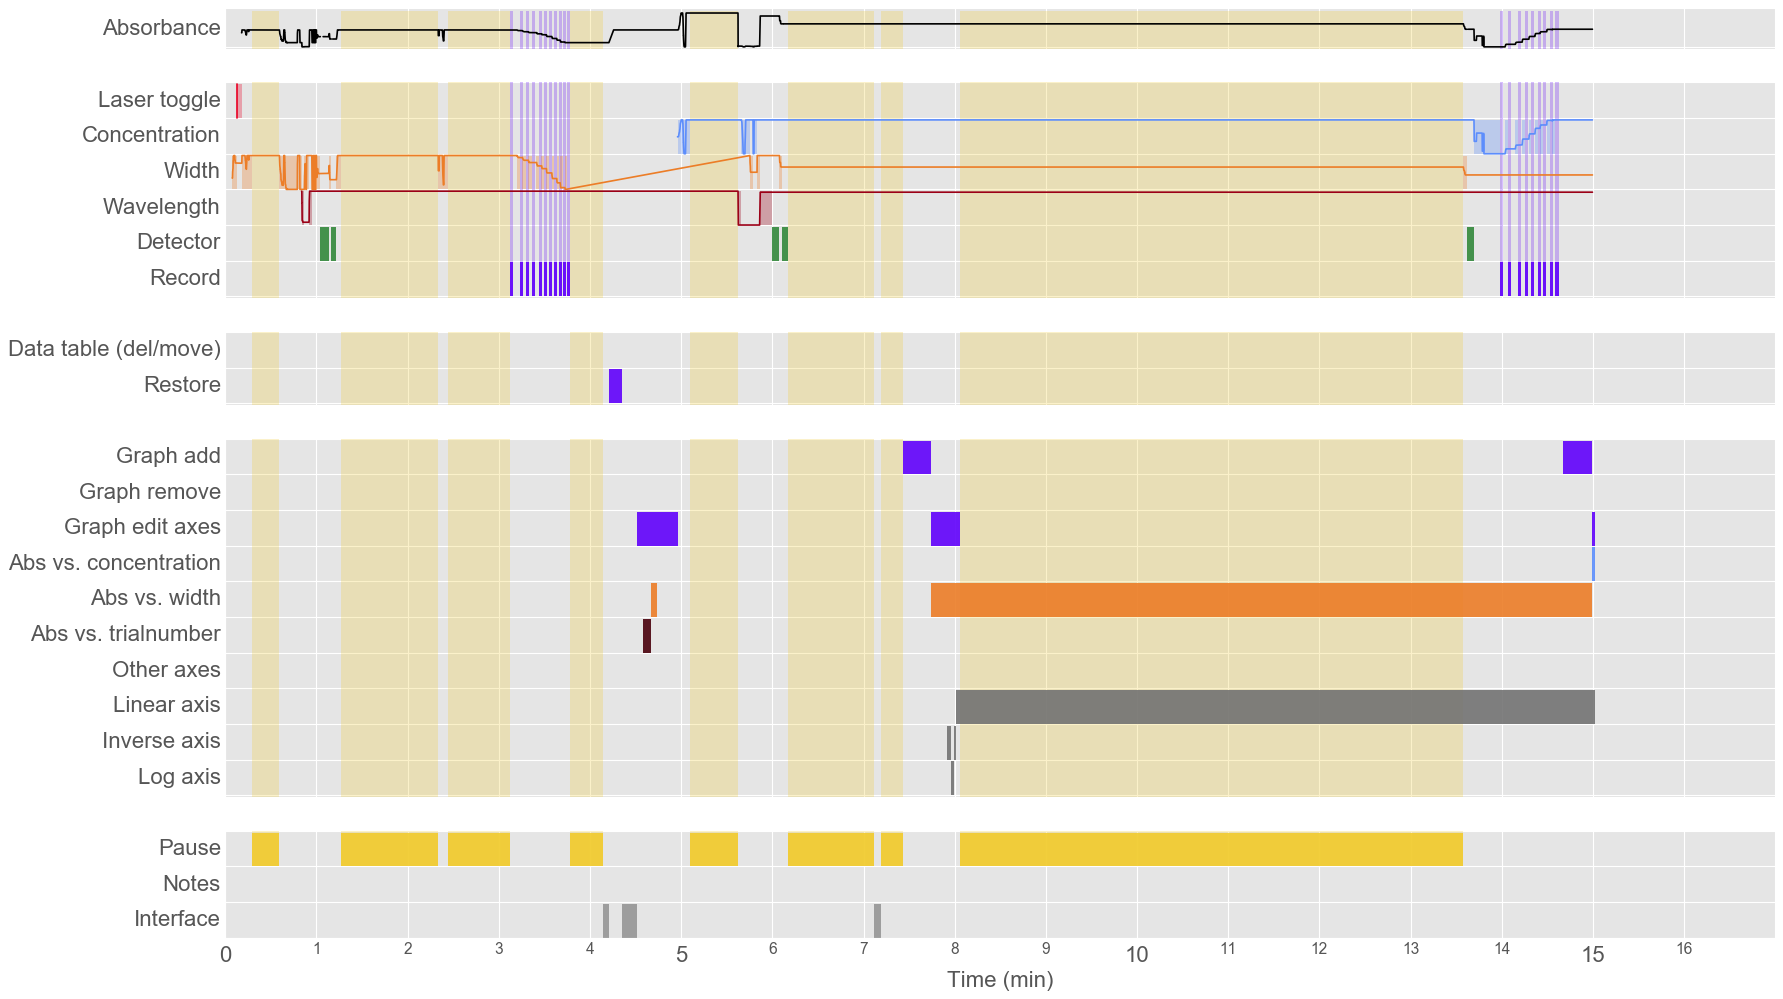

In [3]:
studentid = '16317166'
#main, cdw = 231
parsed_file = find_student_log_file("beers",studentid,date='2017-03-21_17.28.42')
df2 = prep_parsing_data(parsed_file)
plot(df2,to_plot_beers,family_name_to_code,function_to_use,colors)

## Quantitative CVS
First we extract all of their tables at all time points, analyze them for CVS and find the maximum number of values of a variable that was part of a control variable strategy instance.
For now, use of this skill relies on the following production rules (evaluated per variable):
* more than 2 successive records were done where only the variable was changed
* the outcome variable was different for both data points


In [69]:
def get_outcome_values(pts):
    outcomes = []
    for pt in pts:
        if "Charge" in pt.keys():
            outcomes.append(pt["Charge"])
        elif "Absorbance" in pt.keys():
            outcomes.append(pt["Absorbance"])
    return outcomes

def detect_cvs_quant_in_table(table):
    cvs_variable = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}

    variable_changed = None
    number_of_changes = 1
    prev_point = None
    #data points in order of trial number, which is synonomous with 
    #order of capture since when you move data points around in the table,
    #they keep the same trial number
    for datapoint in sorted(table.iterkeys()): 
        curr_point = table[datapoint]
        if prev_point:
            values_of_2_points = get_values_per_variable([prev_point,curr_point])
            confounded = pts_are_confounded(values_of_2_points)
            outcome1,outcome2 = get_outcome_values([prev_point,curr_point])
            #we check that only one variable is changed,
            #that the outcome values are different and that they are not null but floats
            if not confounded and outcome1!= outcome2 and isinstance(outcome1, float) and isinstance(outcome2, float):
                #find the variable being changed
                for v,vals in values_of_2_points.iteritems():
                    if len(vals) > 1:
                        new_var_changed = v
                #update the number of changes for that variable
                if variable_changed == None or new_var_changed == variable_changed:
                    number_of_changes += 1
                else:
                    number_of_changes = 2
                variable_changed = new_var_changed
                cvs_variable[variable_changed] = number_of_changes
            else:
                number_of_changes = 1
                variable_changed = None
        prev_point = curr_point.copy()
    return cvs_variable
            
            
            
def get_cvs_per_variable(df):
    tables = set(df['Table'])
    cvs_final = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}
    for i,t in enumerate(tables):
        table = read_table(t) #converts json string to dictionary
        pts = get_pts(table) #grab all points
        values = get_values_per_variable(pts)
        cvs_final = {k:max(v,detect_cvs_quant_in_table(table)[k]) for k,v in cvs_final.iteritems()}
    return cvs_final

In [70]:
print get_cvs_per_variable(df1)
print get_cvs_per_variable(df2)

{'Battery voltage': 2, 'Area': 3, 'Width': 0, 'Separation': 2, 'Wavelength': 0, 'Concentration': 0}
{'Battery voltage': 0, 'Area': 0, 'Width': 11, 'Separation': 0, 'Wavelength': 0, 'Concentration': 9}
